In [68]:
#importing libraries 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
import json
import pickle

# Supporting Functions

In [4]:
# #convert feature's string values into numbers to apply models
# label_to_key = {}
# key_to_label = {}
# for i,label in enumerate(sorted(df['Class'].unique())):
#     label_to_key[label] = i
#     key_to_label[i]= label

In [69]:
# load the json to convert from num to lable
with open('Data/processing_models/num_to_label.json') as json_file:
    num_to_label = json.load(json_file)

with open('Data/processing_models/label_to_num.json') as json_file:
    label_to_num = json.load(json_file)

num_to_label,label_to_num

({'0': 'H', '1': 'L', '2': 'M'}, {'H': 0, 'L': 1, 'M': 2})

In [70]:
# to save trained model in pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [71]:
# to load trained model 
def load_pkl_model(path):
    return pickle.load(open(path, 'rb'))
    

In [101]:
f1 = make_scorer(f1_score, average='micro')
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
def get_best_estimator(classifier,grid_param,X,y):
    gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring=f1,
                     cv=kf,
                     n_jobs=-1)

    gd_sr.fit(X, y)  # X,y are recently updated values
    
    return gd_sr.best_score_,gd_sr.best_estimator_

In [155]:
# function to drop columns by matching names of columns

def func_dropCol(df,drop_col =['SectionID','StageID','Semester']):
    for i in drop_col:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df



In [126]:
acc_wCol = {}

random_state = 0 


In [198]:
accuracy = {}

# 2. Naive Bays
**using one hot encoded ,bxtransformed data** 
**and important features from above model** 

**Assumptions:**

The biggest and only assumption is the assumption of conditional independence.

**Pros:**

1. Gives high performance when the conditional independence assumption is satisfied.
2. Easy to implement because only probabilities need to be calculated.
3. Works well with high-dimensional data, such as text.
4. Fast for real-time predictions.

**Cons:**

1. If conditional independence does not hold, then is performs poorly.
2. Has the problem of Numerical Stability or Numerical Underflow because of the multiplication of several small digits.
 

In [199]:
# loading classifier 
classifier = GaussianNB()

In [245]:
# reading one hot encoded box transformed data 
df = pd.read_csv("Data/transformed/train_bx_ohe.csv")

In [246]:
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,H
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,M
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,L
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,M
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,H


In [247]:
# checking number of rows(r) and columns(c)  (r,c)
df.shape

(408, 61)

In [248]:
# dropping columns with less importance
df = func_dropCol(df)
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,H
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,M
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,M
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,H


In [249]:
# checking number of rows(r) and columns(c) in (r,c) format
df.shape

(408, 56)

In [205]:
# converting Class feature values from str to number
df.Class = df.Class.apply(lambda x :label_to_key[x]) 
df.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7,Class
0,0.283065,0.915333,-0.046205,1.202617,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
1,-0.248000,0.787987,0.814707,0.738216,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
2,0.283065,0.330558,-0.819927,-0.262502,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.532940,0.744635,0.580670,0.000635,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
4,0.760956,0.998122,0.580670,-1.642231,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0


In [206]:
# extracting input and target features
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [207]:
# setting range of hyperparameters for grid search

#var_smoothingfloat, default=1e-9
##Portion of the largest variance of all features that is added to variances for calculation stability.
grid_param = {
    'var_smoothing': np.logspace(0,-9, num=10)}

In [208]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [209]:
print(best_score,best_random)

0.6813309244203553 GaussianNB(var_smoothing=0.1)


In [136]:
#acc_wCol['naive_bayes'] = best_score

In [210]:
accuracy['naive_bayes'] = best_score

In [211]:
save_pkl_model("models/naive_bayes.pkl",best_random)

# 3. algorithms with Normalized and one hot encoded data

In [250]:
df = pd.read_csv("Data/transformed/train_mms_ohe.csv")
print("shape " , df.shape)
df = func_dropCol(df)

print("shape after removing columns ", df.shape)
df.Class = df.Class.apply(lambda x :label_to_key[x]) # mapping 
df.head()
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

shape  (408, 61)
shape after removing columns  (408, 56)


## 3.1 Decision Trees 
**Assumptions of algorithm** :

1. Initially, whole training data is considered as root.
2. Records are distributed recursively on the basis of the attribute value.

**Pros** :

1. Compared to other algorithms, data preparation requires less time.
2. Doesn’t require data to be normalized.
3. Missing values, to an extent, don’t affect its performance much.
4. Is very intuitive as can be explained as if-else conditions.

**Cons**:

1. Needs a lot of time to train the model.
2. A small change in data can cause a considerably large change in the Decision Tree structure.
3. Comparatively expensive to train.
4. Not good for regression tasks.

https://www.kdnuggets.com/2021/02/machine-learning-assumptions.html 
 

In [213]:
classifier = DecisionTreeClassifier(random_state = random_state)

In [214]:
grid_param = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [215]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [216]:
print(best_score,best_random)

0.7376994881059922 DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=0)


In [217]:
#acc_wCol['Decision_Tree'] = best_score
accuracy['Decision_Tree'] = best_score

In [218]:
save_pkl_model("models/decision_tree.pkl",best_random)

# 3.2 Random forest

In [219]:
classifier = RandomForestClassifier(random_state = random_state)

In [220]:

grid_param = {
    'n_estimators': [int(x) for x in range(200,2000,200)],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [221]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [222]:
print(best_score,best_random)

0.8062631737428486 RandomForestClassifier(bootstrap=False, n_estimators=1200, random_state=0)


In [223]:
#acc_wCol['Random_forest'] = best_score
accuracy['Random_forest'] = best_score

In [224]:
save_pkl_model("models/random_forest.pkl",best_random)

# 3.3 Logistic regression 

In [225]:
classifier = LogisticRegression(random_state = random_state)

In [226]:
grid_param =  {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 3),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000]
    }

In [227]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ProBook\AppData\Roaming\Python\Python38\site-packages\sklearn

In [228]:
print(best_score,best_random)

0.7719963866305328 LogisticRegression(penalty='l1', random_state=0, solver='saga')


In [229]:
#acc_wCol['Logistic_regression'] = best_score
accuracy['Logistic_regression'] = best_score

In [230]:
save_pkl_model("models/logistic_regression.pkl",best_random)

# 3.4 SVM
**Assumptions:**

It assumes data is independent and identically distributed.

**Pros:**

1. Works really well on high dimensional data.
2. Memory efficient.
3. Effective in cases where the number of dimensions is greater than the number of samples.

**Cons:**

1. Not suitable for large datasets.
2. Doesn’t work well when the dataset has noise, i.e., the target classes are overlapping.
3. Slow to train.
4. No probabilistic explanation for classification.

In [231]:
classifier = SVC(random_state = random_state)

In [232]:
grid_param = { 'C':[0.1,1,100,1000],
'kernel':['rbf','poly','sigmoid','linear'],
'degree':[1,5,6]
}

In [233]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

In [234]:
print(best_score,best_random)

0.7769346582354713 SVC(C=1, degree=1, random_state=0)


In [235]:
#acc_wCol['svm'] = best_score
accuracy['svm'] = best_score

In [236]:
save_pkl_model("models/svm.pkl",best_random)

# 3.5 XGBOOST

**Assumptions:**

It may have an assumption that encoded integer value for each variable has ordinal relation.

**Pros:**

1. Can work in parallell.
2. Can handle missing values.
3. No need for scaling or normalizing data.
4. Fast to interpret.
5. Great execution speed.

**Cons:**

1. Can easily overfit if parameters are not tuned properly.
2. Hard to tune.

In [237]:
classifier = XGBClassifier()

In [238]:
# grid search cross validation
grid_param  = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2],
    'min_samples_leaf': [1,2],
    'max_leaf_nodes': [4,50,None]
}

In [239]:
best_score,best_random = get_best_estimator(classifier,grid_param,X,y)

[12:47:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [240]:
print(best_score,best_random)

0.7326708822643783 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              criterion='gini', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaf_nodes=4, max_leaves=0, min_child_weight=1,
              min_samples_leaf=1, min_samples_split=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, ...)


In [241]:
#acc_wCol['Xgboost'] = best_score
accuracy['Xgboost'] = best_score

In [243]:
save_pkl_model("models/xgboost.pkl",best_random)

In [188]:
acc_wCol

{'naive_bayes': 0.6788015657934356,
 'Decision_Tree': 0.7205962059620595,
 'Random_forest': 0.7988557663354412,
 'Logistic_regression': 0.7842818428184282,
 'svm': 0.7842818428184282,
 'Xgboost': 0.720385426076483}

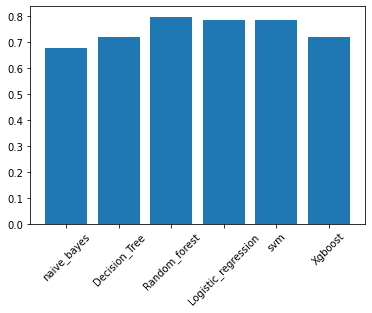

In [197]:
import matplotlib.pyplot as plt
plt.bar(range(len(acc_wCol)), list(acc_wCol.values()), align='center')
plt.xticks(range(len(acc_wCol)), list(acc_wCol.keys()), rotation = 45)
plt.show()

In [242]:
accuracy

{'naive_bayes': 0.6813309244203553,
 'Decision_Tree': 0.7376994881059922,
 'Random_forest': 0.8062631737428486,
 'Logistic_regression': 0.7719963866305328,
 'svm': 0.7769346582354713,
 'Xgboost': 0.7326708822643783}

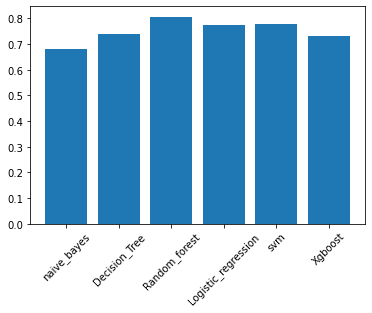

In [244]:
import matplotlib.pyplot as plt
plt.bar(range(len(accuracy)), list(accuracy.values()), align='center')
plt.xticks(range(len(accuracy)), list(accuracy.keys()), rotation = 45)
plt.show()

# 3.6 Neural network 